# Orbital & Atomic DOS Contribution Analysis (Fixed)
**Changes from v1:**
1. Window reduced from 0.5 eV to **0.05 eV** (configurable). Also computes 0.1 and 0.5 for comparison.
2. DOS plot now shows **actual data points** (scatter) + **cubic spline interpolation** for smooth curve.
3. VBM, CBM, and **first neighboring grid points** are labeled with exact values.
4. Spin channels handled correctly for SOC (sum up+down).

---

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from scipy.interpolate import CubicSpline
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.core import Spin, OrbitalType
import os
from pathlib import Path

### ISbSe-343d2125478e

In [12]:
# ============================================================
# CONFIGURATION - CHANGE THESE
# ============================================================
compound_dir = r"C:\Users\AbCMS_Lab\Desktop\Keshav-DDP\Inverse-design\rashba\ISbSe-343d2125478e"
compound_uid = "ISbSe-343d2125478e"
vasprun_path = os.path.join(compound_dir, f"ss_2d%2F{compound_uid}%2Fbands_ncl%2Fvasprun.xml")

# Window size in eV (your PhD guide suggested ~0.05)
# We compute for all 3 and compare
WINDOW_SMALL = 0.05   # PhD guide's suggestion
WINDOW_MED = 0.1      # middle ground
WINDOW_LARGE = 0.5    # original (too large)

# Primary window to use for pie charts and final descriptors
PRIMARY_WINDOW = WINDOW_SMALL

print(f"Processing: {compound_dir}")
print(f"Vasprun: {vasprun_path}")
print(f"File exists: {os.path.exists(vasprun_path)}")
print(f"\nPrimary window: {PRIMARY_WINDOW} eV")


Processing: C:\Users\AbCMS_Lab\Desktop\Keshav-DDP\Inverse-design\rashba\ISbSe-343d2125478e
Vasprun: C:\Users\AbCMS_Lab\Desktop\Keshav-DDP\Inverse-design\rashba\ISbSe-343d2125478e\ss_2d%2FISbSe-343d2125478e%2Fbands_ncl%2Fvasprun.xml
File exists: True

Primary window: 0.05 eV


In [13]:
# ============================================================
# PARSE VASPRUN & GET BAND EDGES
# ============================================================
vr = Vasprun(vasprun_path, parse_dos=True, parse_eigen=False)
complete_dos = vr.complete_dos
structure = vr.final_structure

e_fermi = vr.efermi
vbm = complete_dos.get_cbm_vbm()[1]
cbm = complete_dos.get_cbm_vbm()[0]
bandgap = cbm - vbm

print(f"Fermi Energy: {e_fermi:.4f} eV")
print(f"VBM: {vbm:.4f} eV (absolute)")
print(f"CBM: {cbm:.4f} eV (absolute)")
print(f"Band Gap: {bandgap:.4f} eV")

# Shift to Fermi = 0
vbm_shifted = vbm - e_fermi
cbm_shifted = cbm - e_fermi
energies = complete_dos.energies - e_fermi

# Handle SOC spin channels
if Spin.down in complete_dos.densities:
    total_dos = complete_dos.densities[Spin.up] + complete_dos.densities[Spin.down]
    spin_info = "SOC/spin-polarized (summing both channels)"
else:
    total_dos = complete_dos.densities[Spin.up]
    spin_info = "Non-spin-polarized (single channel)"

print(f"\nSpin handling: {spin_info}")
print(f"VBM (shifted): {vbm_shifted:.4f} eV")
print(f"CBM (shifted): {cbm_shifted:.4f} eV")
print(f"Energy grid: {len(energies)} points, range [{energies.min():.2f}, {energies.max():.2f}] eV")

# Energy grid spacing
de = np.diff(energies)
print(f"Energy grid spacing: min={de.min():.5f}, max={de.max():.5f}, mean={de.mean():.5f} eV")

Fermi Energy: -1.7165 eV
VBM: -1.7218 eV (absolute)
CBM: -1.0061 eV (absolute)
Band Gap: 0.7158 eV

Spin handling: Non-spin-polarized (single channel)
VBM (shifted): -0.0053 eV
CBM (shifted): 0.7105 eV
Energy grid: 301 points, range [-14.84, 9.75] eV
Energy grid spacing: min=0.08190, max=0.08200, mean=0.08197 eV


In [14]:
# ============================================================
# ANALYZE ENERGY GRID NEAR BAND EDGES
# This is the key diagnostic your prof wants to see
# ============================================================

def find_nearest_idx(arr, val):
    return np.argmin(np.abs(arr - val))

# Find grid points closest to VBM and CBM
vbm_idx = find_nearest_idx(energies, vbm_shifted)
cbm_idx = find_nearest_idx(energies, cbm_shifted)

print("=" * 60)
print("ENERGY GRID POINTS NEAR VBM")
print("=" * 60)
for offset in range(-3, 4):
    idx = vbm_idx + offset
    if 0 <= idx < len(energies):
        marker = " <-- VBM" if offset == 0 else ""
        dist = abs(energies[idx] - vbm_shifted)
        print(f"  idx={idx:5d}, E={energies[idx]:+.5f} eV, DOS={total_dos[idx]:.4f}, "
              f"dist_from_VBM={dist:.5f} eV{marker}")

print(f"\n  Actual VBM energy: {vbm_shifted:.5f} eV")
print(f"  Nearest grid point: {energies[vbm_idx]:.5f} eV (off by {abs(energies[vbm_idx]-vbm_shifted):.5f} eV)")

# First point BELOW VBM with nonzero DOS
for i in range(vbm_idx, max(vbm_idx-20, 0), -1):
    if total_dos[i] > 0.01:
        print(f"  First point with DOS > 0.01 at/below VBM: E={energies[i]:.5f}, DOS={total_dos[i]:.4f}")
        break

print("\n" + "=" * 60)
print("ENERGY GRID POINTS NEAR CBM")
print("=" * 60)
for offset in range(-3, 4):
    idx = cbm_idx + offset
    if 0 <= idx < len(energies):
        marker = " <-- CBM" if offset == 0 else ""
        dist = abs(energies[idx] - cbm_shifted)
        print(f"  idx={idx:5d}, E={energies[idx]:+.5f} eV, DOS={total_dos[idx]:.4f}, "
              f"dist_from_CBM={dist:.5f} eV{marker}")

print(f"\n  Actual CBM energy: {cbm_shifted:.5f} eV")
print(f"  Nearest grid point: {energies[cbm_idx]:.5f} eV (off by {abs(energies[cbm_idx]-cbm_shifted):.5f} eV)")

# First point ABOVE CBM with nonzero DOS
for i in range(cbm_idx, min(cbm_idx+20, len(energies))):
    if total_dos[i] > 0.01:
        print(f"  First point with DOS > 0.01 at/above CBM: E={energies[i]:.5f}, DOS={total_dos[i]:.4f}")
        break

# How many points in each window?
for w_name, w_size in [("0.05 eV", 0.05), ("0.1 eV", 0.1), ("0.5 eV", 0.5)]:
    vbm_mask = (energies >= vbm_shifted - w_size) & (energies <= vbm_shifted)
    cbm_mask = (energies >= cbm_shifted) & (energies <= cbm_shifted + w_size)
    print(f"\n  Window {w_name}: {vbm_mask.sum()} points in VBM window, {cbm_mask.sum()} points in CBM window")

ENERGY GRID POINTS NEAR VBM
  idx=  178, E=-0.25107 eV, DOS=2.4104, dist_from_VBM=0.24577 eV
  idx=  179, E=-0.16907 eV, DOS=1.2511, dist_from_VBM=0.16377 eV
  idx=  180, E=-0.08707 eV, DOS=0.0518, dist_from_VBM=0.08177 eV
  idx=  181, E=-0.00507 eV, DOS=0.0000, dist_from_VBM=0.00023 eV <-- VBM
  idx=  182, E=+0.07683 eV, DOS=0.0000, dist_from_VBM=0.08213 eV
  idx=  183, E=+0.15883 eV, DOS=0.0000, dist_from_VBM=0.16413 eV
  idx=  184, E=+0.24083 eV, DOS=0.0000, dist_from_VBM=0.24613 eV

  Actual VBM energy: -0.00530 eV
  Nearest grid point: -0.00507 eV (off by 0.00023 eV)
  First point with DOS > 0.01 at/below VBM: E=-0.08707, DOS=0.0518

ENERGY GRID POINTS NEAR CBM
  idx=  187, E=+0.48673 eV, DOS=0.0000, dist_from_CBM=0.22372 eV
  idx=  188, E=+0.56863 eV, DOS=0.0000, dist_from_CBM=0.14182 eV
  idx=  189, E=+0.65063 eV, DOS=0.0000, dist_from_CBM=0.05982 eV
  idx=  190, E=+0.73263 eV, DOS=0.0002, dist_from_CBM=0.02218 eV <-- CBM
  idx=  191, E=+0.81453 eV, DOS=0.1307, dist_from_CBM=0.1

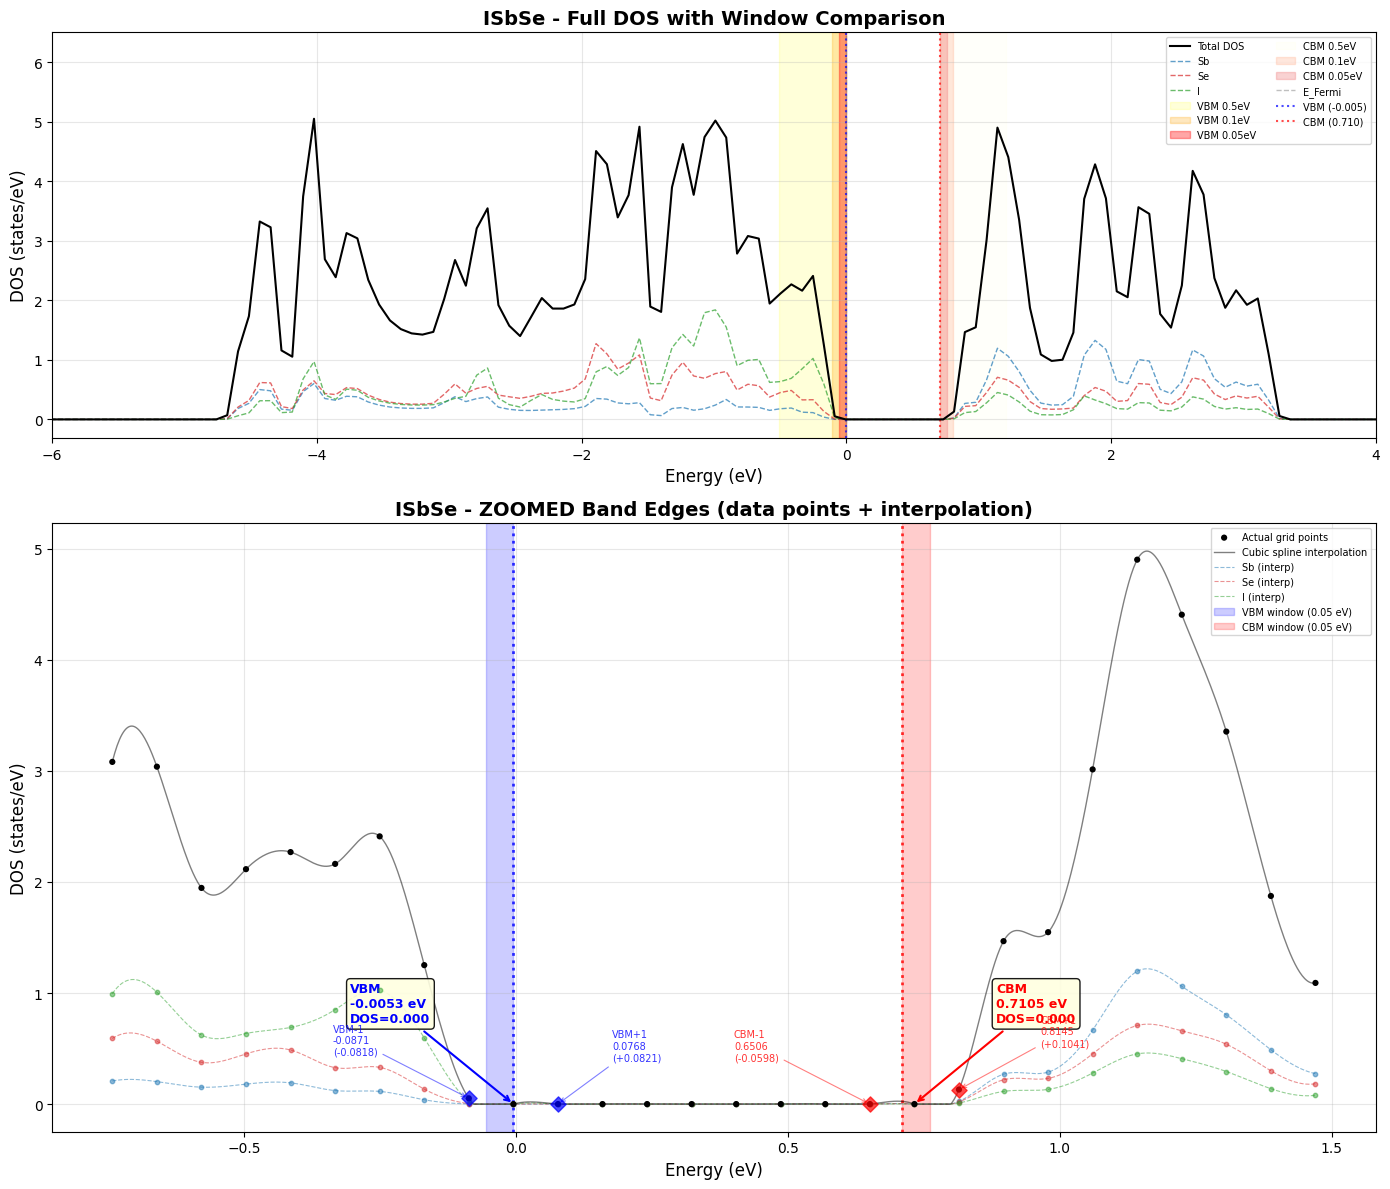

Saved: dos_band_edges_zoomed.png


In [15]:
# ============================================================
# PLOT 1: DOS with actual data points + interpolation
# Zoomed into band edges, showing VBM/CBM and neighbors
# ============================================================

compound_name = os.path.basename(compound_dir).split('-')[0]

# Get element DOS
element_dos = complete_dos.get_element_dos()
el_colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b']

def get_dos_values(dos_obj):
    """Extract DOS values, summing spin channels for SOC."""
    if Spin.down in dos_obj.densities:
        return dos_obj.densities[Spin.up] + dos_obj.densities[Spin.down]
    return dos_obj.densities[Spin.up]

# --- FULL VIEW ---
fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 1.5]})

# Top: Full DOS
ax = axes[0]
ax.plot(energies, total_dos, 'k-', lw=1.5, label='Total DOS', zorder=3)
for i, element in enumerate(element_dos):
    el_dos_vals = get_dos_values(element_dos[element])
    ax.plot(energies, el_dos_vals, '--', lw=1, color=el_colors[i % len(el_colors)],
            label=str(element), alpha=0.7, zorder=2)

# Highlight all 3 windows for VBM
for w_size, w_color, w_alpha, w_label in [
    (0.5, 'yellow', 0.15, 'VBM 0.5eV'),
    (0.1, 'orange', 0.25, 'VBM 0.1eV'),
    (0.05, 'red', 0.35, 'VBM 0.05eV')
]:
    mask = (energies >= vbm_shifted - w_size) & (energies <= vbm_shifted)
    ax.axvspan(vbm_shifted - w_size, vbm_shifted, alpha=w_alpha, color=w_color, label=w_label)

# Same for CBM
for w_size, w_color, w_alpha, w_label in [
    (0.5, 'lightyellow', 0.15, 'CBM 0.5eV'),
    (0.1, 'lightsalmon', 0.25, 'CBM 0.1eV'),
    (0.05, 'lightcoral', 0.35, 'CBM 0.05eV')
]:
    mask = (energies >= cbm_shifted) & (energies <= cbm_shifted + w_size)
    ax.axvspan(cbm_shifted, cbm_shifted + w_size, alpha=w_alpha, color=w_color, label=w_label)

ax.axvline(x=0, color='gray', ls='--', lw=1, alpha=0.5, label='E_Fermi')
ax.axvline(x=vbm_shifted, color='blue', ls=':', lw=1.5, alpha=0.7, label=f'VBM ({vbm_shifted:.3f})')
ax.axvline(x=cbm_shifted, color='red', ls=':', lw=1.5, alpha=0.7, label=f'CBM ({cbm_shifted:.3f})')
ax.set_xlabel('Energy (eV)', fontsize=12)
ax.set_ylabel('DOS (states/eV)', fontsize=12)
ax.set_title(f'{compound_name} - Full DOS with Window Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=7, ncol=2)
ax.set_xlim([-6, 4])
ax.grid(True, alpha=0.3)

# --- BOTTOM: ZOOMED view near band edges with DATA POINTS ---
ax2 = axes[1]

# Zoom range: slightly beyond the 0.5eV windows
zoom_lo = vbm_shifted - 0.8
zoom_hi = cbm_shifted + 0.8
zoom_mask = (energies >= zoom_lo) & (energies <= zoom_hi)
e_zoom = energies[zoom_mask]
dos_zoom = total_dos[zoom_mask]

# Plot actual data points as scatter
ax2.scatter(e_zoom, dos_zoom, s=20, c='black', zorder=5, label='Actual grid points', edgecolors='none')

# Cubic spline interpolation (only where we have points)
if len(e_zoom) > 3:
    cs = CubicSpline(e_zoom, dos_zoom)
    e_fine = np.linspace(e_zoom.min(), e_zoom.max(), 1000)
    dos_fine = cs(e_fine)
    dos_fine = np.maximum(dos_fine, 0)  # no negative DOS
    ax2.plot(e_fine, dos_fine, 'k-', lw=1, alpha=0.5, label='Cubic spline interpolation', zorder=3)

# Element projected DOS in zoom region
for i, element in enumerate(element_dos):
    el_dos_vals = get_dos_values(element_dos[element])
    el_zoom = el_dos_vals[zoom_mask]
    ax2.scatter(e_zoom, el_zoom, s=10, color=el_colors[i % len(el_colors)], alpha=0.5, zorder=4)
    if len(e_zoom) > 3:
        cs_el = CubicSpline(e_zoom, el_zoom)
        dos_el_fine = np.maximum(cs_el(e_fine), 0)
        ax2.plot(e_fine, dos_el_fine, '--', lw=0.8, color=el_colors[i % len(el_colors)],
                 alpha=0.5, label=f'{element} (interp)', zorder=2)

# Mark VBM, CBM with big markers
ax2.axvline(x=vbm_shifted, color='blue', ls=':', lw=2, alpha=0.8)
ax2.axvline(x=cbm_shifted, color='red', ls=':', lw=2, alpha=0.8)

# Annotate VBM point
vbm_dos_val = total_dos[vbm_idx]
ax2.annotate(f'VBM\n{vbm_shifted:.4f} eV\nDOS={vbm_dos_val:.3f}',
             xy=(energies[vbm_idx], vbm_dos_val),
             xytext=(energies[vbm_idx]-0.3, vbm_dos_val + max(dos_zoom)*0.15),
             fontsize=9, fontweight='bold', color='blue',
             arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.9))

# Annotate CBM point
cbm_dos_val = total_dos[cbm_idx]
ax2.annotate(f'CBM\n{cbm_shifted:.4f} eV\nDOS={cbm_dos_val:.3f}',
             xy=(energies[cbm_idx], cbm_dos_val),
             xytext=(energies[cbm_idx]+0.15, cbm_dos_val + max(dos_zoom)*0.15),
             fontsize=9, fontweight='bold', color='red',
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.9))

# Annotate first neighbors of VBM (previous and next grid points)
for offset, label_prefix in [(-1, 'VBM-1'), (+1, 'VBM+1')]:
    idx = vbm_idx + offset
    if 0 <= idx < len(energies):
        ax2.scatter([energies[idx]], [total_dos[idx]], s=60, c='blue', marker='D', zorder=6, alpha=0.7)
        gap = energies[idx] - vbm_shifted
        ax2.annotate(f'{label_prefix}\n{energies[idx]:.4f}\n({gap:+.4f})',
                     xy=(energies[idx], total_dos[idx]),
                     xytext=(energies[idx] + (0.1 if offset > 0 else -0.25), total_dos[idx] + max(dos_zoom)*0.08),
                     fontsize=7, color='blue', alpha=0.8,
                     arrowprops=dict(arrowstyle='->', color='blue', alpha=0.5, lw=0.8))

# Annotate first neighbors of CBM
for offset, label_prefix in [(-1, 'CBM-1'), (+1, 'CBM+1')]:
    idx = cbm_idx + offset
    if 0 <= idx < len(energies):
        ax2.scatter([energies[idx]], [total_dos[idx]], s=60, c='red', marker='D', zorder=6, alpha=0.7)
        gap = energies[idx] - cbm_shifted
        ax2.annotate(f'{label_prefix}\n{energies[idx]:.4f}\n({gap:+.4f})',
                     xy=(energies[idx], total_dos[idx]),
                     xytext=(energies[idx] + (0.15 if offset > 0 else -0.25), total_dos[idx] + max(dos_zoom)*0.08),
                     fontsize=7, color='red', alpha=0.8,
                     arrowprops=dict(arrowstyle='->', color='red', alpha=0.5, lw=0.8))

# Show windows
ax2.axvspan(vbm_shifted - PRIMARY_WINDOW, vbm_shifted, alpha=0.2, color='blue', label=f'VBM window ({PRIMARY_WINDOW} eV)')
ax2.axvspan(cbm_shifted, cbm_shifted + PRIMARY_WINDOW, alpha=0.2, color='red', label=f'CBM window ({PRIMARY_WINDOW} eV)')

ax2.set_xlabel('Energy (eV)', fontsize=12)
ax2.set_ylabel('DOS (states/eV)', fontsize=12)
ax2.set_title(f'{compound_name} - ZOOMED Band Edges (data points + interpolation)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=7)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dos_band_edges_zoomed.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dos_band_edges_zoomed.png")

In [16]:
# ============================================================
# CONTRIBUTION CALCULATION - ALL 3 WINDOWS
# ============================================================

def integrate_dos_window(energies, dos_values, window):
    """Integrate DOS within energy window using trapezoidal rule."""
    mask = (energies >= window[0]) & (energies <= window[1])
    e_w = energies[mask]
    d_w = dos_values[mask]
    if len(e_w) < 2:
        return 0.0
    return np.trapezoid(d_w, e_w)

def compute_contributions(energies, complete_dos, element_dos, vbm_shifted, cbm_shifted, window_size):
    """Compute orbital and atomic contributions for a given window size."""
    vbm_win = [vbm_shifted - window_size, vbm_shifted]
    cbm_win = [cbm_shifted, cbm_shifted + window_size]
    
    orbital_map = {'s': OrbitalType.s, 'p': OrbitalType.p, 'd': OrbitalType.d}
    contributions = {}
    
    for element in element_dos:
        el_name = str(element)
        contributions[el_name] = {}
        spd_dos = complete_dos.get_element_spd_dos(element)
        
        for orb_str in ['s', 'p', 'd']:
            orb_type = orbital_map[orb_str]
            if orb_type in spd_dos:
                if Spin.down in spd_dos[orb_type].densities:
                    orb_dos = spd_dos[orb_type].densities[Spin.up] + spd_dos[orb_type].densities[Spin.down]
                else:
                    orb_dos = spd_dos[orb_type].densities[Spin.up]
                
                contributions[el_name][orb_str] = {
                    'VBM': integrate_dos_window(energies, orb_dos, vbm_win),
                    'CBM': integrate_dos_window(energies, orb_dos, cbm_win)
                }
            else:
                contributions[el_name][orb_str] = {'VBM': 0.0, 'CBM': 0.0}
    
    # Normalize
    total_vbm = sum(contributions[el][orb]['VBM'] for el in contributions for orb in ['s','p','d'])
    total_cbm = sum(contributions[el][orb]['CBM'] for el in contributions for orb in ['s','p','d'])
    
    normalized = {}
    for el in contributions:
        normalized[el] = {}
        for orb in ['s','p','d']:
            normalized[el][orb] = {
                'VBM': contributions[el][orb]['VBM'] / total_vbm if total_vbm > 0 else 0,
                'CBM': contributions[el][orb]['CBM'] / total_cbm if total_cbm > 0 else 0
            }
    
    return contributions, normalized, total_vbm, total_cbm

# Compute for all 3 windows
results = {}
for w_name, w_size in [('0.05eV', 0.05), ('0.1eV', 0.1), ('0.5eV', 0.5)]:
    raw, norm, t_vbm, t_cbm = compute_contributions(
        energies, complete_dos, element_dos, vbm_shifted, cbm_shifted, w_size)
    results[w_name] = {'raw': raw, 'norm': norm, 'total_vbm': t_vbm, 'total_cbm': t_cbm}

# Print comparison table
print(f"{'Window':<10} {'Total VBM':<12} {'Total CBM':<12} {'VBM pts':<10} {'CBM pts':<10}")
print("-" * 55)
for w_name, w_size in [('0.05eV', 0.05), ('0.1eV', 0.1), ('0.5eV', 0.5)]:
    vbm_mask = (energies >= vbm_shifted - w_size) & (energies <= vbm_shifted)
    cbm_mask = (energies >= cbm_shifted) & (energies <= cbm_shifted + w_size)
    r = results[w_name]
    print(f"{w_name:<10} {r['total_vbm']:<12.4f} {r['total_cbm']:<12.4f} {vbm_mask.sum():<10} {cbm_mask.sum():<10}")

print("\n" + "=" * 60)
print("CONTRIBUTION COMPARISON ACROSS WINDOWS")
print("=" * 60)
for el in results['0.05eV']['norm']:
    print(f"\n--- {el} ---")
    for orb in ['s', 'p', 'd']:
        vals_vbm = [f"{results[w]['norm'][el][orb]['VBM']*100:.1f}%" for w in ['0.05eV','0.1eV','0.5eV']]
        vals_cbm = [f"{results[w]['norm'][el][orb]['CBM']*100:.1f}%" for w in ['0.05eV','0.1eV','0.5eV']]
        print(f"  {orb}-VBM: {vals_vbm[0]:>7} | {vals_vbm[1]:>7} | {vals_vbm[2]:>7}   (0.05 | 0.1 | 0.5)")
        print(f"  {orb}-CBM: {vals_cbm[0]:>7} | {vals_cbm[1]:>7} | {vals_cbm[2]:>7}")

Window     Total VBM    Total CBM    VBM pts    CBM pts   
-------------------------------------------------------
0.05eV     0.0000       0.0000       0          1         
0.1eV      0.0000       0.0000       1          1         
0.5eV      0.4553       0.3181       6          6         

CONTRIBUTION COMPARISON ACROSS WINDOWS

--- Sb ---
  s-VBM:    0.0% |    0.0% |    7.8%   (0.05 | 0.1 | 0.5)
  s-CBM:    0.0% |    0.0% |    0.5%
  p-VBM:    0.0% |    0.0% |    1.7%   (0.05 | 0.1 | 0.5)
  p-CBM:    0.0% |    0.0% |   44.3%
  d-VBM:    0.0% |    0.0% |    0.5%   (0.05 | 0.1 | 0.5)
  d-CBM:    0.0% |    0.0% |    2.7%

--- Se ---
  s-VBM:    0.0% |    0.0% |    0.4%   (0.05 | 0.1 | 0.5)
  s-CBM:    0.0% |    0.0% |    3.3%
  p-VBM:    0.0% |    0.0% |   26.6%   (0.05 | 0.1 | 0.5)
  p-CBM:    0.0% |    0.0% |   27.4%
  d-VBM:    0.0% |    0.0% |    0.1%   (0.05 | 0.1 | 0.5)
  d-CBM:    0.0% |    0.0% |    2.1%

--- I ---
  s-VBM:    0.0% |    0.0% |    0.1%   (0.05 | 0.1 | 0.5)
  s-C

In [17]:
# ============================================================
# USE PRIMARY WINDOW FOR FINAL ANALYSIS
# ============================================================

w_key = f"{PRIMARY_WINDOW}eV"
if w_key not in results:
    w_key = '0.05eV'  # fallback

normalized_contrib = results[w_key]['norm']

# Atomic weights
atomic_weights = {}
for el in normalized_contrib:
    vbm_total = sum(normalized_contrib[el][orb]['VBM'] for orb in ['s','p','d'])
    cbm_total = sum(normalized_contrib[el][orb]['CBM'] for orb in ['s','p','d'])
    atomic_weights[el] = {'VBM': vbm_total * 100, 'CBM': cbm_total * 100}

# Orbital weights
orbital_weights = {}
for orb in ['s','p','d']:
    vbm_total = sum(normalized_contrib[el][orb]['VBM'] for el in normalized_contrib)
    cbm_total = sum(normalized_contrib[el][orb]['CBM'] for el in normalized_contrib)
    orbital_weights[orb] = {'VBM': vbm_total * 100, 'CBM': cbm_total * 100}

print(f"Using window: {PRIMARY_WINDOW} eV")
print(f"\nAtomic Contributions (window = {PRIMARY_WINDOW} eV):")
for el in atomic_weights:
    print(f"  {el}: VBM={atomic_weights[el]['VBM']:.2f}%, CBM={atomic_weights[el]['CBM']:.2f}%")

print(f"\nOrbital Contributions (window = {PRIMARY_WINDOW} eV):")
for orb in ['s','p','d']:
    print(f"  {orb}: VBM={orbital_weights[orb]['VBM']:.2f}%, CBM={orbital_weights[orb]['CBM']:.2f}%")

Using window: 0.05 eV

Atomic Contributions (window = 0.05 eV):
  Sb: VBM=0.00%, CBM=0.00%
  Se: VBM=0.00%, CBM=0.00%
  I: VBM=0.00%, CBM=0.00%

Orbital Contributions (window = 0.05 eV):
  s: VBM=0.00%, CBM=0.00%
  p: VBM=0.00%, CBM=0.00%
  d: VBM=0.00%, CBM=0.00%


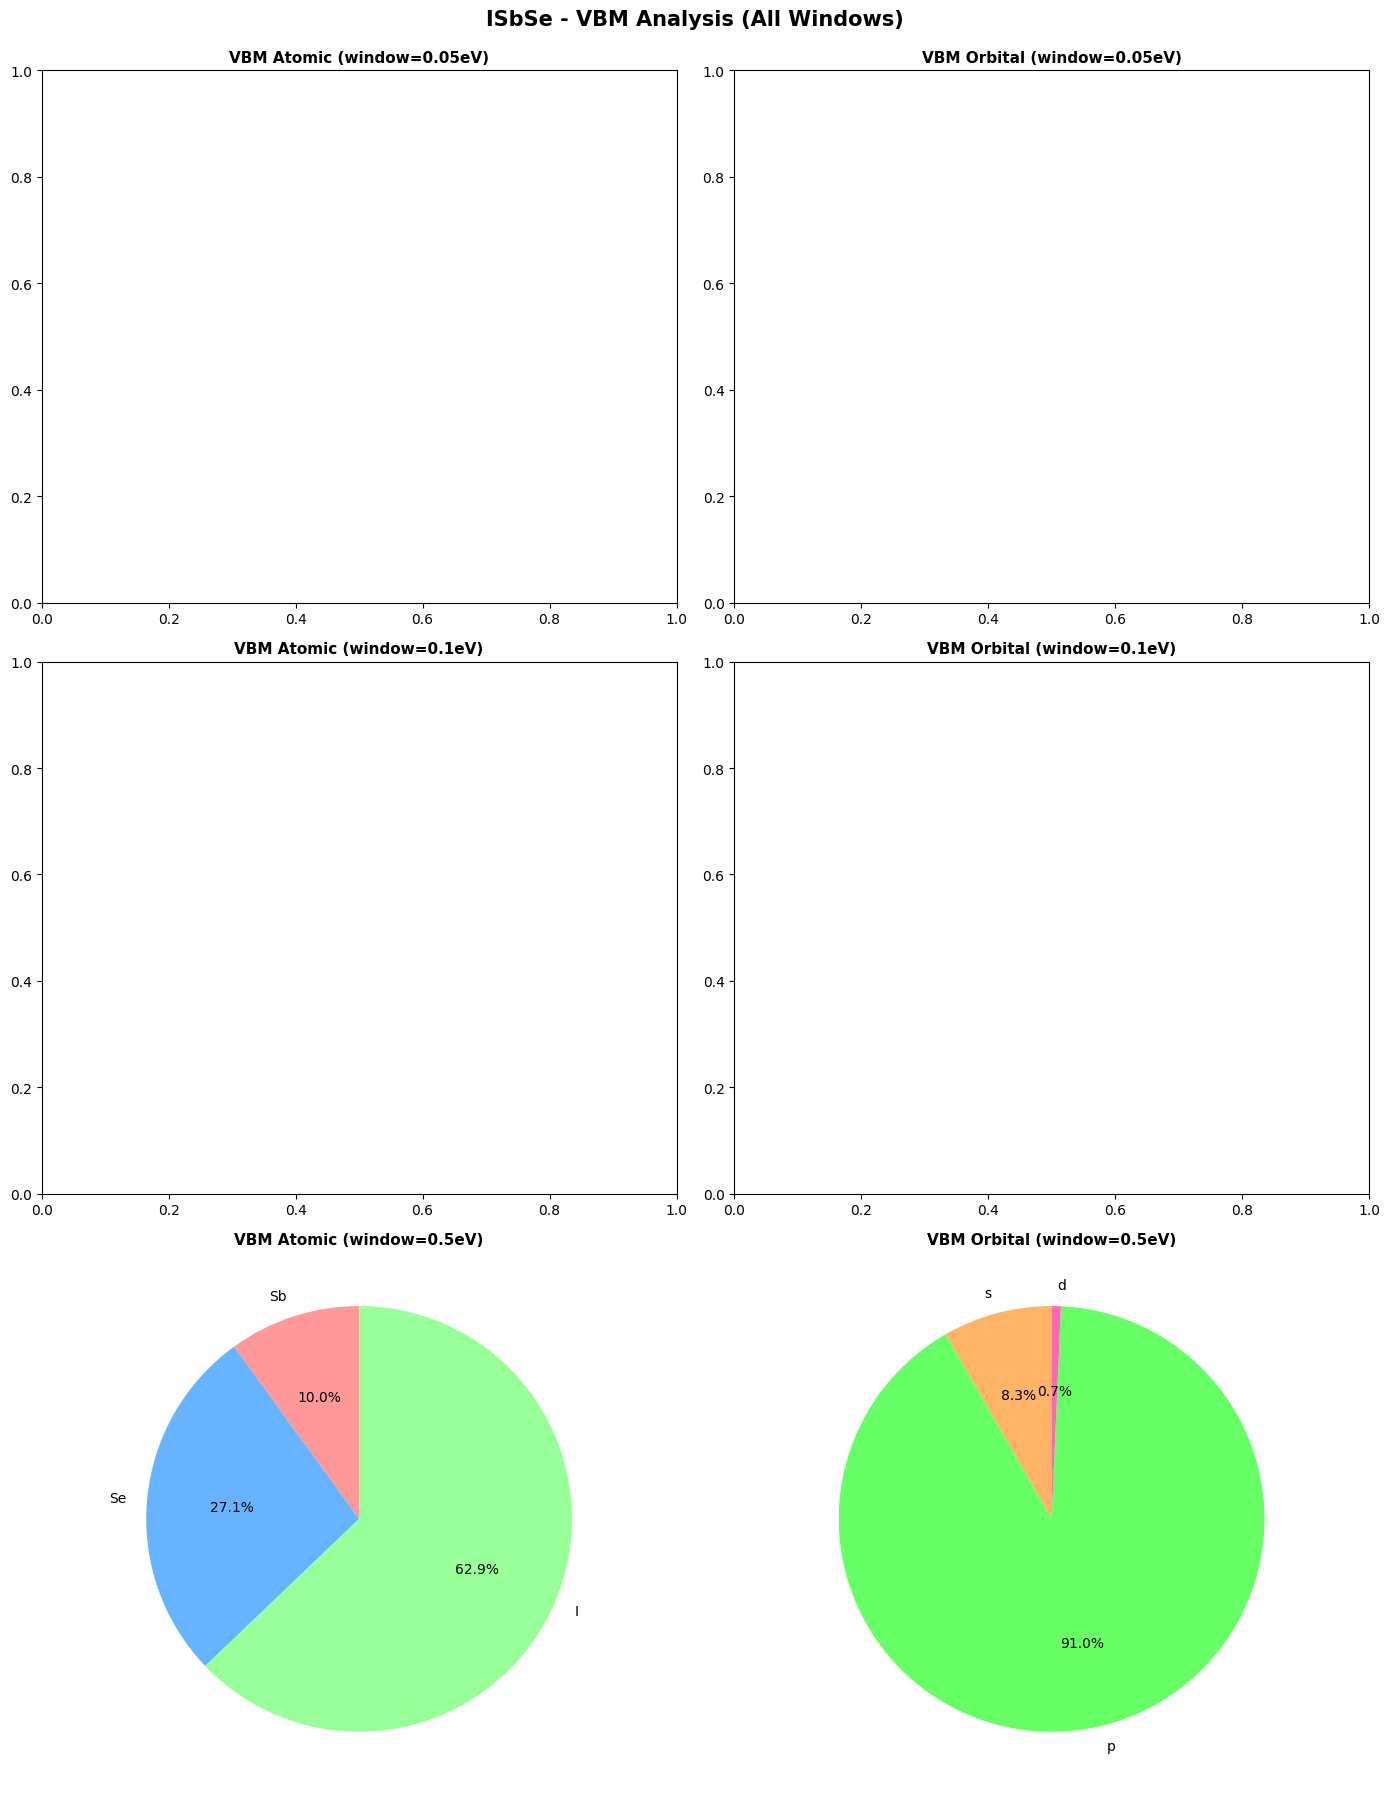

In [18]:
# ============================================================
# PIE CHARTS - VBM (ALL 3 WINDOWS)
# ============================================================
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
colors_atomic = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
colors_orbital = ['#ffb366', '#66ff66', '#ff66b3']

window_list = [('0.05eV', 0.05), ('0.1eV', 0.1), ('0.5eV', 0.5)]

for row_idx, (w_name, w_size) in enumerate(window_list):
    # Get contributions for this window
    norm_w = results[w_name]['norm']
    
    # Calculate atomic and orbital weights for this window
    atomic_w = {}
    for el in norm_w:
        vbm_total = sum(norm_w[el][orb]['VBM'] for orb in ['s','p','d'])
        atomic_w[el] = vbm_total * 100
    
    orbital_w = {}
    for orb in ['s','p','d']:
        vbm_total = sum(norm_w[el][orb]['VBM'] for el in norm_w)
        orbital_w[orb] = vbm_total * 100
    
    # VBM Atomic
    ax1 = axes[row_idx, 0]
    atomic_labels = list(atomic_w.keys())
    atomic_vbm_values = [atomic_w[el] for el in atomic_labels]
    nonzero = [(l, v) for l, v in zip(atomic_labels, atomic_vbm_values) if v > 0.5]
    if nonzero:
        labels, values = zip(*nonzero)
        ax1.pie(values, labels=labels, autopct='%1.1f%%',
                colors=colors_atomic[:len(labels)], startangle=90, textprops={'fontsize': 10})
    ax1.set_title(f'VBM Atomic (window={w_name})', fontsize=11, fontweight='bold')
    
    # VBM Orbital
    ax2 = axes[row_idx, 1]
    orbital_labels = ['s', 'p', 'd']
    orbital_vbm_values = [orbital_w[orb] for orb in orbital_labels]
    nonzero = [(l, v) for l, v in zip(orbital_labels, orbital_vbm_values) if v > 0.5]
    if nonzero:
        labels, values = zip(*nonzero)
        ax2.pie(values, labels=labels, autopct='%1.1f%%',
                colors=colors_orbital[:len(labels)], startangle=90, textprops={'fontsize': 10})
    ax2.set_title(f'VBM Orbital (window={w_name})', fontsize=11, fontweight='bold')

plt.suptitle(f'{compound_name} - VBM Analysis (All Windows)', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('vbm_contributions.png', dpi=150, bbox_inches='tight')
plt.show()


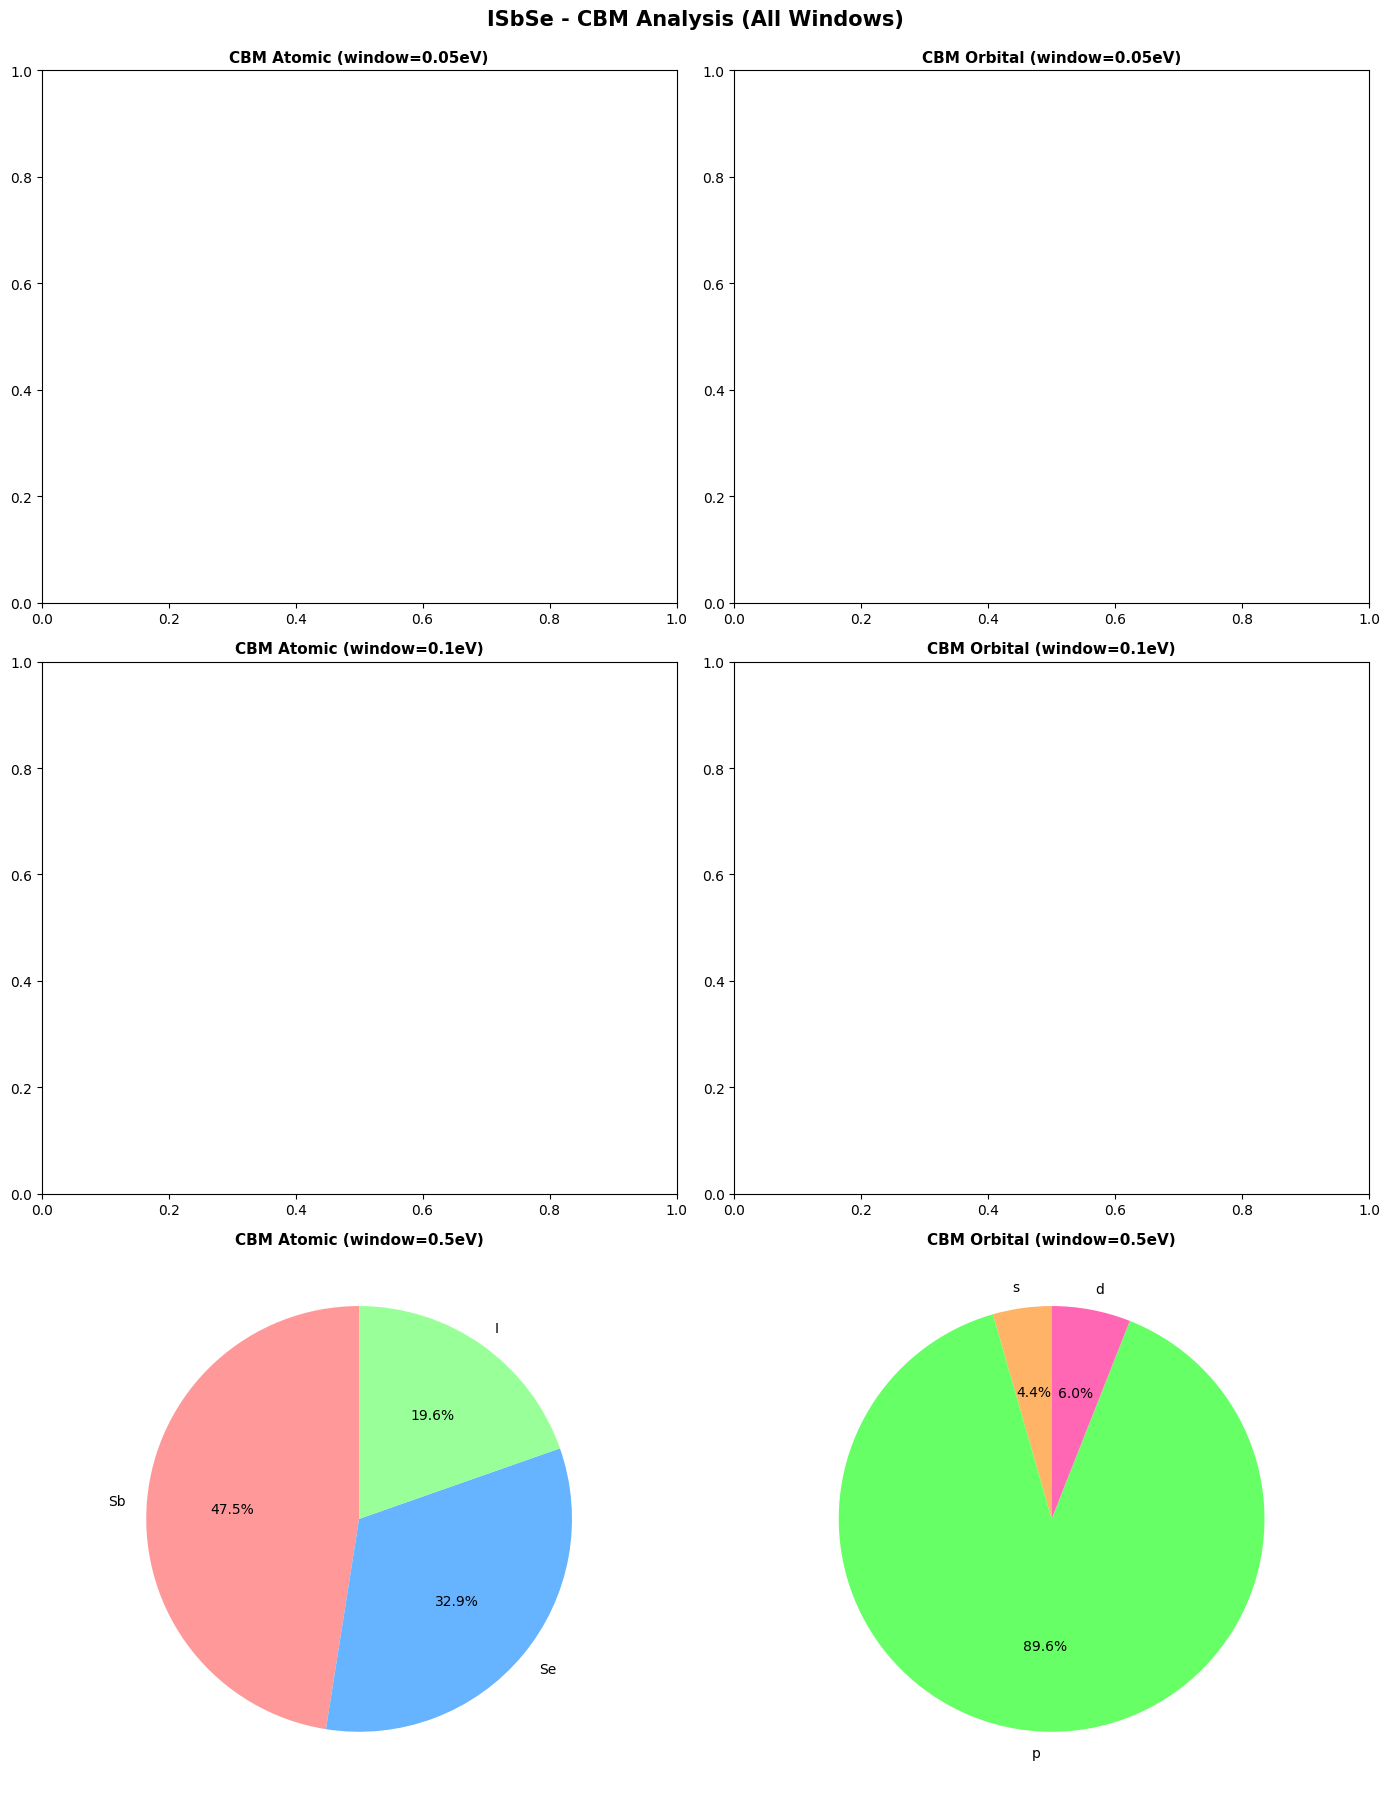

In [19]:
# ============================================================
# PIE CHARTS - CBM (ALL 3 WINDOWS)
# ============================================================
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
colors_atomic = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
colors_orbital = ['#ffb366', '#66ff66', '#ff66b3']

window_list = [('0.05eV', 0.05), ('0.1eV', 0.1), ('0.5eV', 0.5)]

for row_idx, (w_name, w_size) in enumerate(window_list):
    # Get contributions for this window
    norm_w = results[w_name]['norm']
    
    # Calculate atomic and orbital weights for this window
    atomic_w = {}
    for el in norm_w:
        cbm_total = sum(norm_w[el][orb]['CBM'] for orb in ['s','p','d'])
        atomic_w[el] = cbm_total * 100
    
    orbital_w = {}
    for orb in ['s','p','d']:
        cbm_total = sum(norm_w[el][orb]['CBM'] for el in norm_w)
        orbital_w[orb] = cbm_total * 100
    
    # CBM Atomic
    ax1 = axes[row_idx, 0]
    atomic_labels = list(atomic_w.keys())
    atomic_cbm_values = [atomic_w[el] for el in atomic_labels]
    nonzero = [(l, v) for l, v in zip(atomic_labels, atomic_cbm_values) if v > 0.5]
    if nonzero:
        labels, values = zip(*nonzero)
        ax1.pie(values, labels=labels, autopct='%1.1f%%',
                colors=colors_atomic[:len(labels)], startangle=90, textprops={'fontsize': 10})
    ax1.set_title(f'CBM Atomic (window={w_name})', fontsize=11, fontweight='bold')
    
    # CBM Orbital
    ax2 = axes[row_idx, 1]
    orbital_labels = ['s', 'p', 'd']
    orbital_cbm_values = [orbital_w[orb] for orb in orbital_labels]
    nonzero = [(l, v) for l, v in zip(orbital_labels, orbital_cbm_values) if v > 0.5]
    if nonzero:
        labels, values = zip(*nonzero)
        ax2.pie(values, labels=labels, autopct='%1.1f%%',
                colors=colors_orbital[:len(labels)], startangle=90, textprops={'fontsize': 10})
    ax2.set_title(f'CBM Orbital (window={w_name})', fontsize=11, fontweight='bold')

plt.suptitle(f'{compound_name} - CBM Analysis (All Windows)', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('cbm_contributions.png', dpi=150, bbox_inches='tight')
plt.show()


In [20]:
# ============================================================
# SUMMARY: FINAL DESCRIPTOR ROW FOR THIS MATERIAL
# ============================================================
print("=" * 60)
print(f"DESCRIPTOR ROW FOR: {compound_name}")
print(f"Window: {PRIMARY_WINDOW} eV")
print("=" * 60)

descriptor_row = {'compound': compound_name, 'window_eV': PRIMARY_WINDOW}

for el in normalized_contrib:
    for orb in ['s', 'p', 'd']:
        for band in ['VBM', 'CBM']:
            key = f"{el}_{orb}_{band}"
            val = normalized_contrib[el][orb][band]
            descriptor_row[key] = round(val, 6)
            print(f"  {key}: {val:.4f} ({val*100:.2f}%)")

# Atomic totals
for el in atomic_weights:
    for band in ['VBM', 'CBM']:
        key = f"{el}_total_{band}"
        val = atomic_weights[el][band] / 100
        descriptor_row[key] = round(val, 6)

# Orbital totals
for orb in ['s', 'p', 'd']:
    for band in ['VBM', 'CBM']:
        key = f"{orb}_total_{band}"
        val = orbital_weights[orb][band] / 100
        descriptor_row[key] = round(val, 6)

# Band gap
descriptor_row['bandgap_eV'] = round(bandgap, 4)

print(f"\nTotal features: {len(descriptor_row)}")
print(f"\nFull row (dict):")
for k, v in descriptor_row.items():
    print(f"  {k}: {v}")

DESCRIPTOR ROW FOR: ISbSe
Window: 0.05 eV
  Sb_s_VBM: 0.0000 (0.00%)
  Sb_s_CBM: 0.0000 (0.00%)
  Sb_p_VBM: 0.0000 (0.00%)
  Sb_p_CBM: 0.0000 (0.00%)
  Sb_d_VBM: 0.0000 (0.00%)
  Sb_d_CBM: 0.0000 (0.00%)
  Se_s_VBM: 0.0000 (0.00%)
  Se_s_CBM: 0.0000 (0.00%)
  Se_p_VBM: 0.0000 (0.00%)
  Se_p_CBM: 0.0000 (0.00%)
  Se_d_VBM: 0.0000 (0.00%)
  Se_d_CBM: 0.0000 (0.00%)
  I_s_VBM: 0.0000 (0.00%)
  I_s_CBM: 0.0000 (0.00%)
  I_p_VBM: 0.0000 (0.00%)
  I_p_CBM: 0.0000 (0.00%)
  I_d_VBM: 0.0000 (0.00%)
  I_d_CBM: 0.0000 (0.00%)

Total features: 33

Full row (dict):
  compound: ISbSe
  window_eV: 0.05
  Sb_s_VBM: 0
  Sb_s_CBM: 0
  Sb_p_VBM: 0
  Sb_p_CBM: 0
  Sb_d_VBM: 0
  Sb_d_CBM: 0
  Se_s_VBM: 0
  Se_s_CBM: 0
  Se_p_VBM: 0
  Se_p_CBM: 0
  Se_d_VBM: 0
  Se_d_CBM: 0
  I_s_VBM: 0
  I_s_CBM: 0
  I_p_VBM: 0
  I_p_CBM: 0
  I_d_VBM: 0
  I_d_CBM: 0
  Sb_total_VBM: 0.0
  Sb_total_CBM: 0.0
  Se_total_VBM: 0.0
  Se_total_CBM: 0.0
  I_total_VBM: 0.0
  I_total_CBM: 0.0
  s_total_VBM: 0.0
  s_total_CBM: 0.0
  